:warning:**IMPORTANT NOTICE**:warning:\
*Since the initial parameterisation and gradient descent optimisation are stochastic processes, the training of a neural network is not fully reproducible.*

*Therefore, it is not recommended to re-run this script as it will overwrite the original calibration of the neural network used in the work presented here.
The purpose of this script is solely to document the training procedure and can be copied as a template to fit other new neural networks.*

*To experiment with the models calibrated here, they can be loaded from the `saved_models` directory.*

# Train a baseline neural network

Predict pressure and temperature from biotite composition.\
The data are simulated biotite composition - pressure - temperature triples. These data were generated using phase equilibrium modelling (Theriak-Domino).

### Initial hyperparameter
**Performance metrics:**
- Mean Absolute Error (MAE)
- Root Mean Square Error (RMSE)
    - RMSE inverse transformed for pressure and temperature

**Last layer activation function:**
- Linear --> Regression problem

**Loss function:**
- Mean Squared Error (MSE)

**Optimizer:**
- Adam

### Goal
RMSE should be lass than a temperature uncertainty of 25°C and a pressure uncertainty of 1 kbar.\
Performance is assesed on a validation set of 25% of the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import h5py

from pathlib import Path
from keras.models import Sequential
from keras.layers import Dense, Normalization
from keras.losses import MeanSquaredError
from keras.optimizers import Adam, schedules
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from keras.callbacks import CSVLogger, EarlyStopping
from sklearn.model_selection import train_test_split

from ml_tb.normalisation import MinMaxScaler
from ml_tb.metrics import rootmeansquarerror_temperature_denormalised, rootmeansquarerror_pressure_denormalised

## Import data and pre-processing

Load the data from hdf5 file.

In [2]:
# load hdf file
file = Path("10022024_Biotite_ds62.hdf5")
with h5py.File(file, "r") as hdf_file:
    PT = np.array(hdf_file["PT"])
    full_biotite_composition = np.array(hdf_file["mineral_composition"])
    element_idx = hdf_file["mineral_composition"].attrs["element idx [apfu]"]

print(*enumerate(element_idx))

(0, 'O') (1, 'SI') (2, 'TI') (3, 'AL') (4, 'FE') (5, 'MG') (6, 'MN') (7, 'CA') (8, 'NA') (9, 'K') (10, 'H')


In [3]:
biotite_composition = full_biotite_composition[:,1:7]
pt = PT

In [4]:
biotite_composition_train, biotite_composition_val, pt_train, pt_val = train_test_split(biotite_composition, pt, test_size=0.10, shuffle=True)

In [5]:
normalisation_biotite_composition = Normalization(axis=-1)
normalisation_biotite_composition.adapt(biotite_composition_train)

print(normalisation_biotite_composition.mean.numpy())
print(np.sqrt(normalisation_biotite_composition.variance.numpy()))

scaling_pt = MinMaxScaler(min=[1500, 400], max=[10000, 900], axis=0)
inv_scaling_pt = MinMaxScaler(min=[1500, 400], max=[10000, 900], axis=0, invert=True)
pt_train_norm = scaling_pt(pt_train)
pt_val_norm = scaling_pt(pt_val)


[[2.6775463  0.11015439 1.5237241  1.5179147  1.1602144  0.01044587]]
[[0.09314793 0.0468036  0.1657316  0.31421566 0.2735182  0.00942441]]


### Build model

In [6]:
def RMSE_P(y_true, y_pred):
    return rootmeansquarerror_pressure_denormalised(y_true, y_pred, inv_scaling_pt)


def RMSE_T(y_true, y_pred):
    return rootmeansquarerror_temperature_denormalised(y_true, y_pred, inv_scaling_pt)

In [7]:
BATCH_SIZE = 500
STEPS_PER_EPOCH = len(biotite_composition_train) // BATCH_SIZE
MAX_EPOCHS = 1000

CALLLBACKS = [CSVLogger("baseline.log", append=False), EarlyStopping(monitor="val_loss", patience=50)]

In [8]:
lr_schedule = schedules.InverseTimeDecay(0.001, decay_steps=STEPS_PER_EPOCH*1000, decay_rate=1, staircase=False)

In [9]:
OPT = Adam(lr_schedule)
LOSS = MeanSquaredError()
METRICS = [MeanAbsoluteError(), RootMeanSquaredError(), RMSE_P, RMSE_T]

In [10]:
model = Sequential()
model.add(normalisation_biotite_composition)
model.add(Dense(16, activation="elu"))
model.add(Dense(16, activation="elu"))
model.add(Dense(2))

model.compile(optimizer=OPT, loss=LOSS, metrics=METRICS)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 6)                 13        
 on)                                                             
                                                                 
 dense (Dense)               (None, 16)                112       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 431 (1.69 KB)
Trainable params: 418 (1.63 KB)
Non-trainable params: 13 (56.00 Byte)
_________________________________________________________________


### Training

In [11]:
history = model.fit(biotite_composition_train, pt_train_norm, batch_size=BATCH_SIZE, epochs=MAX_EPOCHS, validation_data=[biotite_composition_val, pt_val_norm], callbacks=CALLLBACKS)

Epoch 1/1000




119/119 [==============================] - 2s 5ms/step - loss: 0.1071 - mean_absolute_error: 0.2334 - root_mean_squared_error: 0.3272 - RMSE_P: 2359.4763 - RMSE_T: 94.5847 - val_loss: 0.0334 - val_mean_absolute_error: 0.1350 - val_root_mean_squared_error: 0.1828 - val_RMSE_P: 1637.9052 - val_RMSE_T: 38.6718
Epoch 2/1000
119/119 [==============================] - 0s 3ms/step - loss: 0.0298 - mean_absolute_error: 0.1254 - root_mean_squared_error: 0.1726 - RMSE_P: 1572.5862 - RMSE_T: 32.9007 - val_loss: 0.0270 - val_mean_absolute_error: 0.1170 - val_root_mean_squared_error: 0.1645 - val_RMSE_P: 1515.6039 - val_RMSE_T: 27.8276
Epoch 3/1000
119/119 [==============================] - 0s 2ms/step - loss: 0.0252 - mean_absolute_error: 0.1114 - root_mean_squared_error: 0.1586 - RMSE_P: 1467.1115 - RMSE_T: 25.0730 - val_loss: 0.0235 - val_mean_absolute_error: 0.1064 - val_root_mean_squared_error: 0.1532 - val_RMSE_P: 1420.1361 - val_RMSE_T: 22.9101
Epoch 4/1000
119/119 [=======================

In [12]:
model.save(Path("saved_models", "baseline"))

INFO:tensorflow:Assets written to: saved_models\baseline\assets


INFO:tensorflow:Assets written to: saved_models\baseline\assets


(5.0, 20.0)

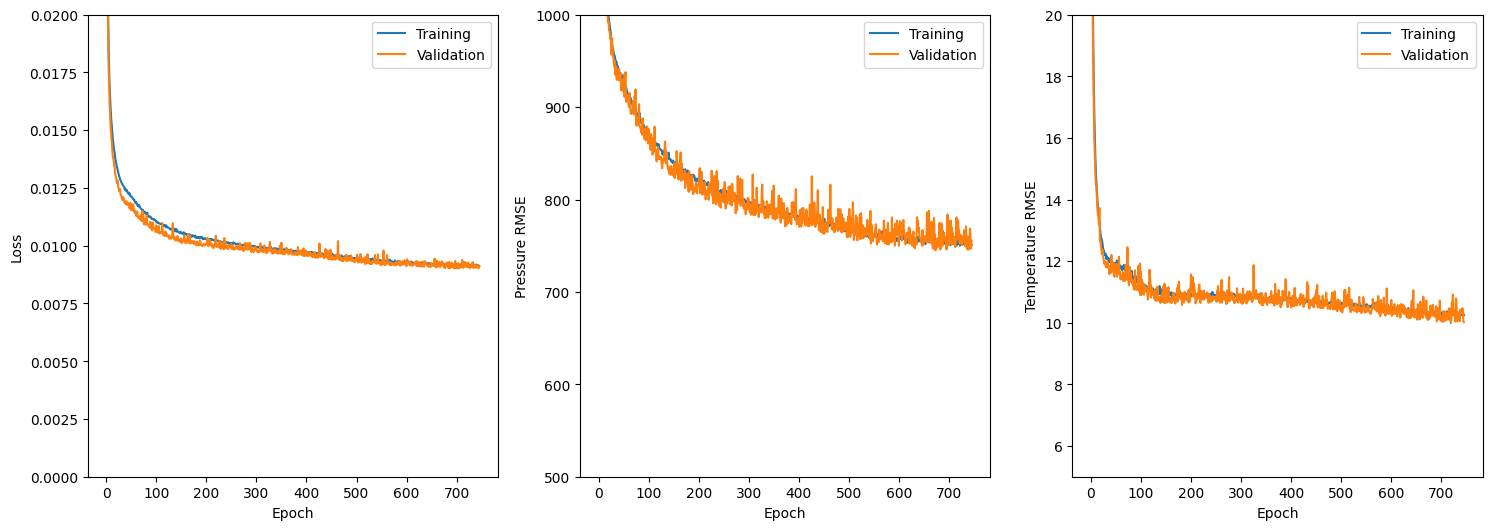

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].plot(history.history["loss"], label="Training")
ax[0].plot(history.history["val_loss"], label="Validation")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].set_ylim(0, 0.02)

ax[1].plot(history.history["RMSE_P"], label="Training")
ax[1].plot(history.history["val_RMSE_P"], label="Validation")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Pressure RMSE")
ax[1].legend()
ax[1].set_ylim(500, 1000)

ax[2].plot(history.history["RMSE_T"], label="Training")
ax[2].plot(history.history["val_RMSE_T"], label="Validation")
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Temperature RMSE")
ax[2].legend()
ax[2].set_ylim(5, 20)